In [1]:
import os.path as osp
import numpy as np
import numpy.linalg as npla
np.set_printoptions(6, suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.serif": ["Helvetica"],
    'font.size': 7,
})

import utils


def load_poses(filename):
    data = np.loadtxt(filename)
    poses = []
    for v in data:
        pose = np.eye(4)
        pose[:3, :] = v.reshape(3, 4)
        poses.append(pose)
    return np.array(poses)


def plot_pred_poses(ax, pred_poses, gt_poses, label, color):
    T_gt_pred = gt_poses[0] @ npla.inv(pred_poses[0])
    pred_poses = T_gt_pred @ pred_poses
    ax.plot(pred_poses[:, 0, 3], pred_poses[:, 1, 3], label=label, linewidth=1.0, color=color)


gt_path = '/home/ywu/ASRL/steam_icp/data/aeva'
pred_path = '/home/ywu/ASRL/steam_icp/src/results/aeva_short/'

In [2]:
### compute trajectory distance
sequences = [
    '00',  # Baker-Barry Tunnel (Empty)
    '01',  # Baker-Barry Tunnel (Vehicles)
    '02',  # Robin Williams Tunnel
    '03',  # Brisbane Lagoon Freeway
]

for sequence in sequences:
  print(f"{sequence}:")
  gt_poses = load_poses(osp.join(gt_path, sequence, 'aeva_poses.txt'))
  distance = utils.trajectory_distances(gt_poses)[-1]
  print(f"  distance: {distance}")

00:
  distance: 865.1829905466136
01:
  distance: 894.3657150814564
02:
  distance: 688.6680784664675
03:
  distance: 4946.907046163074


In [3]:
### compute kitti metric
sequences = [
    '00',  # Baker-Barry Tunnel (Empty)
    '01',  # Baker-Barry Tunnel (Vehicles)
    '02',  # Robin Williams Tunnel
    '03',  # Brisbane Lagoon Freeway
]
methods = ["doppler_icp", "elastic_icp", "steam_icp", "steam_dicp"]
load_gt_fn = lambda sequence: load_poses(osp.join(gt_path, sequence, 'aeva_poses.txt'))[60:]
load_pred_fn = lambda sequence, pred_file: load_poses(osp.join(pred_path, pred_file, sequence + '_poses.txt'))[60:]
utils.print_results(sequences, methods, load_gt_fn, load_pred_fn)


doppler_icp
  00   01   02   03 
elastic_icp
  00   01   02   03 
steam_icp
  00   01   02   03 
steam_dicp
  00   01   02   03 


kitti metric t_err_3d
doppler_icp  & 1.72 & 2.62 & 1.07 & 1.73  & 1.82
elastic_icp  & 2.84 & 12.26 & 9.13 & 1.54  & 3.36
steam_icp  & 2.29 & 12.86 & 22.75 & 2.10  & 4.16
steam_dicp  & 2.36 & 2.61 & 0.74 & 1.70  & 1.89

kitti metric r_err_3d
doppler_icp  & 0.0330 & 0.0143 & 0.0335 & 0.0064  & 0.0122
elastic_icp  & 0.0085 & 0.0148 & 0.0121 & 0.0038  & 0.0062
steam_icp  & 0.0078 & 0.0155 & 0.0124 & 0.0040  & 0.0063
steam_dicp  & 0.0077 & 0.0166 & 0.0137 & 0.0040  & 0.0065

frame-to-frame metric t_err_3d
doppler_icp  & 0.0245 & 0.0241 & 0.0378 & 0.0487  & 0.0396
elastic_icp  & 0.0394 & 0.3750 & 0.2445 & 0.0800  & 0.1825
steam_icp  & 0.0540 & 0.4129 & 0.6076 & 0.2889  & 0.3178
steam_dicp  & 0.0178 & 0.0213 & 0.0299 & 0.0363  & 0.0300

frame-to-frame metric r_err_3d
doppler_icp  & 0.1354 & 0.1671 & 0.1653 & 0.0823  & 0.1160
elastic_icp  & 0.1906 & 0.2866 & 0.159

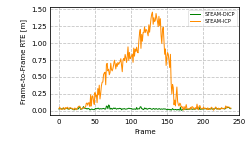

In [4]:
sequences = [
    '00',  # Baker-Barry Tunnel (Empty)
    '01',  # Baker-Barry Tunnel (Vehicles)
    '02',  # Robin Williams Tunnel
    '03',  # Brisbane Lagoon Freeway
]
sequence = sequences[2]

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
fig.subplots_adjust(left=0.2, right=0.95, bottom=0.2, top=0.95, wspace=0.25, hspace=0.25)

gt_poses = load_poses(osp.join(gt_path, sequence, 'aeva_poses.txt'))[60:]

##
pred_file = 'steam_dicp'
pred_poses = load_poses(osp.join(pred_path, pred_file, sequence+'_poses.txt'))[60:]
# rpe metric
t_err, r_err, pose_errors = utils.evaluate_odometry_rpe(gt_poses, pred_poses, 3)
rte = [utils.translation_error(e, 3) for e in pose_errors]
ax.plot(rte, label="STEAM-DICP", linewidth=1.0, color='green')

##
pred_file = 'steam_icp'
pred_poses = load_poses(osp.join(pred_path, pred_file, sequence+'_poses.txt'))[60:]
# rpe metric
t_err, r_err, pose_errors = utils.evaluate_odometry_rpe(gt_poses, pred_poses, 3)
rte = [utils.translation_error(e, 3) for e in pose_errors]
ax.plot(rte, label="STEAM-ICP", linewidth=1.0, color='darkorange')

ax.set_ylabel('Frame-to-Frame RTE [m]')
ax.set_xlabel('Frame')
ax.grid(which='both', linestyle='--', alpha=0.75)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.legend(framealpha=0.5, fontsize=5)

# plt.savefig('/home/yuchen/ASRL/notes/2023-icra-wu/figs/dicp_result/seq02_local_rte.pdf', format="pdf", bbox_inches="tight")
plt.show()

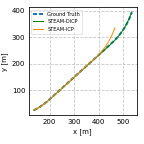

In [5]:
sequences = [
    '00',  # Baker-Barry Tunnel (Empty)
    '01',  # Baker-Barry Tunnel (Vehicles)
    '02',  # Robin Williams Tunnel
    '03',  # Brisbane Lagoon Freeway
]
sequence = sequences[2]

fig, ax = plt.subplots(1, 1, figsize=(2, 2))
fig.subplots_adjust(left=0.2, right=0.95, bottom=0.2, top=0.95, wspace=0.25, hspace=0.25)

gt_poses = load_poses(osp.join(gt_path, sequence, 'aeva_poses.txt'))[60:]
ax.plot(gt_poses[:, 0, 3], gt_poses[:, 1, 3], "--", label='Ground Truth', linewidth=2.0, dashes=(2, 1))

pred_file = 'steam_dicp'
pred_poses = load_poses(osp.join(pred_path, pred_file, sequence + '_poses.txt'))[60:]
plot_pred_poses(ax, pred_poses, gt_poses, 'STEAM-DICP', 'green')

pred_file = 'steam_icp'
pred_poses = load_poses(osp.join(pred_path, pred_file, sequence + '_poses.txt'))[60:]
plot_pred_poses(ax, pred_poses, gt_poses, 'STEAM-ICP', 'darkorange')

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.grid(which='both', linestyle='--', alpha=0.75)
ax.legend(framealpha=0.5, fontsize=5)
ax.tick_params(axis=u'both', which=u'both', length=0)

# plt.savefig('/home/yuchen/ASRL/notes/2023-icra-wu/figs/dicp_result/seq02_path.pdf', format="pdf", bbox_inches="tight")
plt.show()